In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cvxpy as cp
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm

In [2]:
#Load the data from CSMAR, A share from Shanghai Security Exchange
df=pd.read_csv(r"C:\Users\txy20\Desktop\PROJECT\TRD_Mnth.csv")
df=df.dropna()
df.columns=["StockCode","TradingDate","Return"]
# df=df.loc[df["TradingDate"]<="2017-12" ]

In [3]:
#Select the representative shares
stock_list=[11,89,151,417,521,753,888,951,2258,2281,600000,600030,600036,600348,600519,600993,601398,601628,601668,601857]
df1=df.loc[df["StockCode"].isin(stock_list) ]
# df1.set_index(df1["TradingDate"],inplace=True)
df_stock=df1.reset_index()
df_stock=df_stock.iloc[:,1:]
df_stock

,StockCode,TradingDate,Return
0,11,2010-01,-0.089804
1,11,2010-02,0.026721
2,11,2010-03,0.176176
3,11,2010-04,-0.295319
4,11,2010-05,-0.141304
...,...,...,...
2875,601857,2021-08,0.055556
2876,601857,2021-09,0.244431
2877,601857,2021-10,-0.088186
2878,601857,2021-11,-0.140511


In [4]:
#Loading the risk-free
df2=pd.read_csv(r"C:\Users\txy20\Desktop\PROJECT\TRD_Nrrate.csv")
df2["Clsdt"]=pd.to_datetime(df2["Clsdt"])
df2.set_index(df2["Clsdt"],inplace=True)
df2=df2.resample("M").mean()
df_riskfree=df2.reset_index()
df_riskfree["Clsdt"]=df_riskfree["Clsdt"].apply(lambda x: x.strftime('%Y-%m'))
# df_riskfree.set_index(df_riskfree["Clsdt"],inplace=True)
df_riskfree.columns=["TradingDate","Rf"]
df_riskfree["Rf"]=df_riskfree["Rf"]/100
df_riskfree

,TradingDate,Rf
0,2010-01,0.001856
1,2010-02,0.001856
2,2010-03,0.001856
3,2010-04,0.001856
4,2010-05,0.001856
...,...,...
139,2021-08,0.001241
140,2021-09,0.001241
141,2021-10,0.001241
142,2021-11,0.001241


In [5]:
#loading market return
df3=pd.read_csv(r"C:\Users\txy20\Desktop\PROJECT\IDX_Idxtrdmth.csv")
df_market=df3.iloc[:,1:]
df_market.columns=["TradingDate","Rm"]
# df_market.set_index(df_market["TradingDate"],inplace =True)
# df_market=df_market.iloc[:,1]
df_market

,TradingDate,Rm
0,2010-01,-0.103902
1,2010-02,0.024190
2,2010-03,0.019484
3,2010-04,-0.083166
4,2010-05,-0.095883
...,...,...
139,2021-08,-0.001156
140,2021-09,0.012646
141,2021-10,0.008710
142,2021-11,-0.015634


In [6]:
#Select time period
Year=2012
start=str(Year)+"-01"
print(start)
df_market=df_market.loc[df_market["TradingDate"]>=start]
df_riskfree=df_riskfree.loc[df_riskfree["TradingDate"]>=start]
df_stock=df_stock.loc[df_stock["TradingDate"]>=start]
df_stock

2012-01


,StockCode,TradingDate,Return
24,11,2012-01,-0.012966
25,11,2012-02,0.318555
26,11,2012-03,-0.165629
27,11,2012-04,0.217910
28,11,2012-05,-0.050245
...,...,...,...
2875,601857,2021-08,0.055556
2876,601857,2021-09,0.244431
2877,601857,2021-10,-0.088186
2878,601857,2021-11,-0.140511


In [7]:
df_stock_rf=df_stock.merge(df_riskfree,how="outer",on=["TradingDate"])
df_stock_rf

,StockCode,TradingDate,Return,Rf
0,11,2012-01,-0.012966,0.002871
1,89,2012-01,0.053012,0.002871
2,151,2012-01,-0.133721,0.002871
3,417,2012-01,0.012031,0.002871
4,521,2012-01,-0.022573,0.002871
...,...,...,...,...
2395,600993,2021-12,0.200334,0.001241
2396,601398,2021-12,0.010917,0.001241
2397,601628,2021-12,0.018274,0.001241
2398,601668,2021-12,0.077586,0.001241


In [8]:
#Estimate market expectation
df_market_rf=df_market.merge(df_riskfree,how="outer",on=["TradingDate"])
df_market_rf["demean"]=df_market_rf["Rm"]-df_market_rf["Rf"]
df_market_rf['d']=df_market_rf["demean"]-np.mean(df_market_rf["demean"])
df_market_rf["loss"]=df_market_rf["d"]*df_market_rf["d"]
est_var=sum(df_market_rf["loss"])/(df_market_rf.shape[0]-1)
est_var

0.004219032117153703

In [9]:
#calculate estimated covariance w.r.t the market stock for the stocks
sr=[]
mean_stock=dict()
for id in stock_list:
    df6=df_stock_rf.loc[df_stock_rf["StockCode"].isin([id]) ]
    df7=df_market_rf.merge(df6,how="outer",on=["TradingDate","Rf"])
    m=np.mean(df7["Return"])
    mean_stock[id]=m
    df7["Demean"]=df7["Return"]-df7["Rf"]
    df7["D"]=df7["Demean"]-np.mean(df7["Demean"])
    df7["cov"]=df7["d"]*df7["D"]
    est_cov=sum(df7["cov"])/(df_market_rf.shape[0]-1)
    sr.append(est_cov)
sr

[0.005090332670405803,
 0.00392643248563932,
 0.003531156697174238,
 0.004876180658700579,
 0.0039559366087398,
 0.004033891672066442,
 0.002628718851807268,
 0.005351457920973377,
 0.003701478248293817,
 0.0031927383348755566,
 0.0031278517299991693,
 0.007409866698385934,
 0.003946483794721232,
 0.0034103371262349546,
 0.003121496093416486,
 0.0034134856636961674,
 0.0020719601093919914,
 0.005127691991372037,
 0.005444849281406746,
 0.002661629153343322]

In [10]:
#Get beta
beta=[]
for i in sr:
    b=i/est_var
    beta.append(b)
beta=np.array(beta)
beta

array([1.20651669, 0.93064769, 0.83695895, 1.15575813, 0.93764079,
       0.95611779, 0.62306206, 1.26840891, 0.87732877, 0.75674663,
       0.74136713, 1.7562954 , 0.93540027, 0.80832215, 0.73986071,
       0.80906842, 0.49109844, 1.21537164, 1.29054464, 0.6308625 ])

In [11]:
#get expectation of market return 
Erm=np.mean(df_market_rf["Rm"])
Erm

0.008297308333333333

In [12]:
#get the implied return
Pi=[]
for b in beta:
    rf=0.001241
    r=b*(Erm-rf)+rf
    Pi.append(r)
Pi=np.array(Pi)
Pi

array([0.00975455, 0.00780794, 0.00714684, 0.00939639, 0.00785728,
       0.00798766, 0.00563752, 0.01019128, 0.0074317 , 0.00658084,
       0.00647232, 0.01363396, 0.00784147, 0.00694477, 0.00646169,
       0.00695004, 0.00470634, 0.00981704, 0.01034748, 0.00569256])

In [13]:
#organize dataframe 
df_main=pd.DataFrame()
for id in stock_list:
    df8=df_stock.loc[df_stock["StockCode"].isin([id])]
    df_main[id]=df8["Return"].values
    
df_main

,11,89,151,417,521,753,888,951,2258,2281,600000,600030,600036,600348,600519,600993,601398,601628,601668,601857
0,-0.012966,0.053012,-0.133721,0.012031,-0.022573,-0.119048,-0.094381,0.112916,-0.022426,-0.180581,0.085984,0.100927,0.065712,0.229908,-0.035644,-0.153846,0.014151,0.064626,0.054983,0.048255
1,0.318555,0.027460,0.088591,0.075524,0.154734,0.088803,0.103012,0.023358,0.107404,0.095094,0.034707,0.103835,0.017391,0.063739,0.096830,0.069036,0.030232,-0.004792,0.065147,0.030362
2,-0.165629,-0.042316,-0.110974,-0.066970,-0.104000,-0.099291,0.014200,-0.153352,-0.111111,-0.103377,-0.063941,-0.017797,-0.075369,-0.132427,-0.036682,-0.053708,-0.022573,-0.125201,-0.067278,-0.078898
3,0.217910,0.044186,0.120666,0.020906,0.151786,0.173228,0.038772,0.133951,0.024364,0.061491,0.053751,0.121657,0.025210,0.149739,0.140130,0.027703,0.009238,0.112538,0.108197,0.024768
4,-0.050245,-0.022272,-0.019802,-0.089420,0.005814,-0.006711,-0.013315,0.063150,0.041365,0.057205,-0.068013,0.059231,-0.044262,-0.034326,0.053972,-0.021039,-0.034325,-0.042881,-0.005917,-0.048338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.052677,0.035920,0.136740,0.040573,0.086262,0.084000,0.116118,0.087636,-0.037608,-0.133115,0.002215,0.155545,0.052903,0.534787,-0.072061,0.116878,0.006536,0.030000,0.076233,0.055556
116,-0.006563,0.027739,-0.047388,-0.004587,-0.035294,0.014760,-0.023292,-0.172398,-0.064796,-0.057636,-0.005525,-0.015576,0.030433,-0.169824,0.174583,-0.093295,0.008658,0.033287,0.000000,0.244431
117,-0.089182,0.020243,-0.014031,-0.043779,-0.033537,-0.029091,-0.030207,-0.106613,-0.192857,-0.031696,-0.006667,0.023734,0.069772,-0.142624,-0.002142,-0.014476,0.002146,0.000000,-0.029167,-0.088186
118,-0.045331,-0.063492,0.001294,-0.002410,0.050473,0.131086,-0.022951,0.008308,0.370796,0.074228,-0.048098,-0.081530,-0.083009,0.017110,0.057330,-0.048829,-0.019272,-0.008389,-0.004292,-0.140511


In [14]:
#Compute the covariance matrix
Sigma=np.array(df_main.cov())
Sigma

array([[0.02310533, 0.00784116, 0.00819645, 0.00940189, 0.00654251,
        0.00836061, 0.00367936, 0.00749616, 0.00681717, 0.00838207,
        0.00313669, 0.00726648, 0.00298248, 0.00486534, 0.00434322,
        0.00770678, 0.00232856, 0.00529387, 0.0046649 , 0.00295528],
       [0.00784116, 0.00880428, 0.0043604 , 0.00570057, 0.00443312,
        0.00656219, 0.00412055, 0.0044799 , 0.00498467, 0.00516093,
        0.00251745, 0.00567057, 0.00271109, 0.00317985, 0.00279136,
        0.00566147, 0.00162594, 0.00409734, 0.00380775, 0.00190223],
       [0.00819645, 0.0043604 , 0.02182818, 0.00512802, 0.00530853,
        0.00929657, 0.0029396 , 0.00631873, 0.0043213 , 0.00334901,
        0.0029794 , 0.00633066, 0.00301986, 0.00431016, 0.002313  ,
        0.00355704, 0.00223231, 0.00415378, 0.00514403, 0.00262669],
       [0.00940189, 0.00570057, 0.00512802, 0.00987621, 0.00562416,
        0.00709163, 0.00454436, 0.00766479, 0.00574455, 0.00516103,
        0.00331698, 0.00829696, 0.0038595 , 0

In [15]:
#Construct the view measure
#Step 1 the data forms a normal distribution, In this step, we solidize the normality.
dfm=df_stock  #.loc[df_stock["TradingDate"]>="2021-01"]
dfm

,StockCode,TradingDate,Return
24,11,2012-01,-0.012966
25,11,2012-02,0.318555
26,11,2012-03,-0.165629
27,11,2012-04,0.217910
28,11,2012-05,-0.050245
...,...,...,...
2875,601857,2021-08,0.055556
2876,601857,2021-09,0.244431
2877,601857,2021-10,-0.088186
2878,601857,2021-11,-0.140511


In [45]:
dfk=dfm.groupby("StockCode")
mvdf=dfk.agg([np.mean,np.var,np.std,max,min])
mvdf.columns=(["mean","var","std","max","min"])
mvdf.reset_index(inplace=True)
mvdf["count"]=120
mvdf

C:\Users\txy20\AppData\Local\Temp\ipykernel_31512\3497627611.py:2: FutureWarning: ['TradingDate'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  mvdf=dfk.agg([np.mean,np.var,np.std,max,min])


,StockCode,mean,var,std,max,min,count
0,11,0.017404,0.023105,0.152004,0.685985,-0.367081,120
1,89,0.009579,0.008804,0.093831,0.423804,-0.260393,120
2,151,0.010147,0.021828,0.147744,0.911227,-0.326923,120
3,417,0.000167,0.009876,0.099379,0.284926,-0.306496,120
4,521,0.008141,0.015846,0.125880,0.836364,-0.387789,120
5,753,0.009068,0.013795,0.117451,0.490291,-0.342679,120
6,888,0.001182,0.006399,0.079993,0.244842,-0.229727,120
7,951,0.019328,0.016679,0.129149,0.366347,-0.397988,120
8,2258,0.024606,0.014318,0.119658,0.370796,-0.306445,120
9,2281,0.014434,0.015794,0.125675,0.447241,-0.253545,120


In [47]:
dfp=dfm.merge(mvdf)
dfp["statistic"]=(dfp["Return"]-dfp["mean"])/dfp["std"]
np.mean(dfp["statistic"])
np.std(dfp["statistic"])

0.9958246164193104

Text(0.5, 1.0, 'distribution')

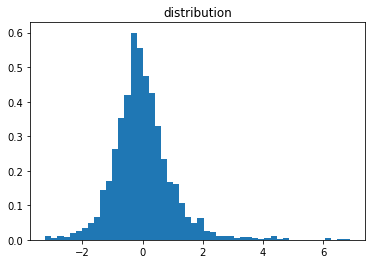

In [48]:
plt.hist(dfp["statistic"],bins=50,density=True)
plt.title("distribution")

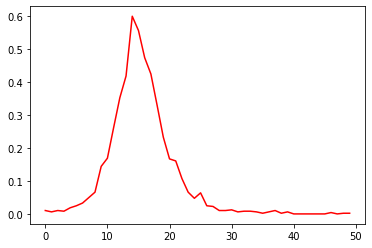

In [19]:
#derive the distribution
pdf,his=np.histogram(dfp["statistic"],bins=50,density=True)
pdf=list(pdf)

# plt.hist(dfp["statistic"],bins=100,density=True)
plt.plot(pdf,color="red")

In [20]:
df_main

,11,89,151,417,521,753,888,951,2258,2281,600000,600030,600036,600348,600519,600993,601398,601628,601668,601857
0,-0.012966,0.053012,-0.133721,0.012031,-0.022573,-0.119048,-0.094381,0.112916,-0.022426,-0.180581,0.085984,0.100927,0.065712,0.229908,-0.035644,-0.153846,0.014151,0.064626,0.054983,0.048255
1,0.318555,0.027460,0.088591,0.075524,0.154734,0.088803,0.103012,0.023358,0.107404,0.095094,0.034707,0.103835,0.017391,0.063739,0.096830,0.069036,0.030232,-0.004792,0.065147,0.030362
2,-0.165629,-0.042316,-0.110974,-0.066970,-0.104000,-0.099291,0.014200,-0.153352,-0.111111,-0.103377,-0.063941,-0.017797,-0.075369,-0.132427,-0.036682,-0.053708,-0.022573,-0.125201,-0.067278,-0.078898
3,0.217910,0.044186,0.120666,0.020906,0.151786,0.173228,0.038772,0.133951,0.024364,0.061491,0.053751,0.121657,0.025210,0.149739,0.140130,0.027703,0.009238,0.112538,0.108197,0.024768
4,-0.050245,-0.022272,-0.019802,-0.089420,0.005814,-0.006711,-0.013315,0.063150,0.041365,0.057205,-0.068013,0.059231,-0.044262,-0.034326,0.053972,-0.021039,-0.034325,-0.042881,-0.005917,-0.048338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.052677,0.035920,0.136740,0.040573,0.086262,0.084000,0.116118,0.087636,-0.037608,-0.133115,0.002215,0.155545,0.052903,0.534787,-0.072061,0.116878,0.006536,0.030000,0.076233,0.055556
116,-0.006563,0.027739,-0.047388,-0.004587,-0.035294,0.014760,-0.023292,-0.172398,-0.064796,-0.057636,-0.005525,-0.015576,0.030433,-0.169824,0.174583,-0.093295,0.008658,0.033287,0.000000,0.244431
117,-0.089182,0.020243,-0.014031,-0.043779,-0.033537,-0.029091,-0.030207,-0.106613,-0.192857,-0.031696,-0.006667,0.023734,0.069772,-0.142624,-0.002142,-0.014476,0.002146,0.000000,-0.029167,-0.088186
118,-0.045331,-0.063492,0.001294,-0.002410,0.050473,0.131086,-0.022951,0.008308,0.370796,0.074228,-0.048098,-0.081530,-0.083009,0.017110,0.057330,-0.048829,-0.019272,-0.008389,-0.004292,-0.140511


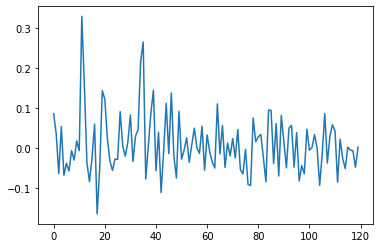

In [21]:
plt.plot(df_main[600000])

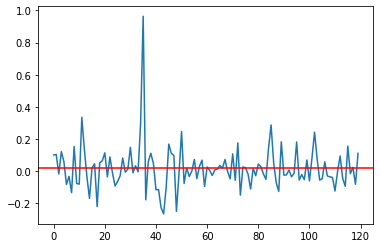

In [22]:
plt.plot(df_main[600030])
plt.axhline(0.018046,color="red")

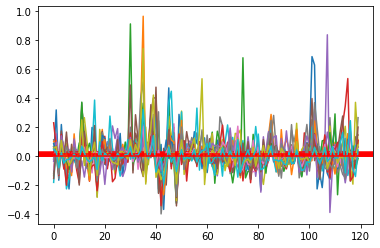

In [23]:
plt.figure(20)
n=1
for stock in stock_list:
    plt.plot(df_main[stock])
    plt.axhline(mvdf.iloc[n-1,1],color="red")
    n+=1

Text(0.5, 1.0, '11')

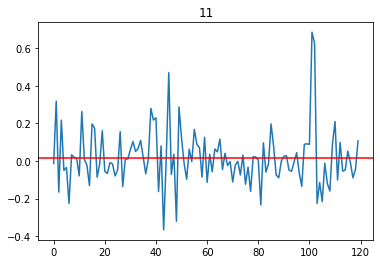

In [24]:
n=0
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '89')

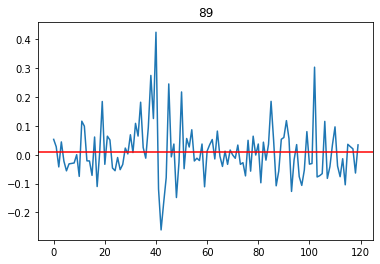

In [25]:
n=1
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '151')

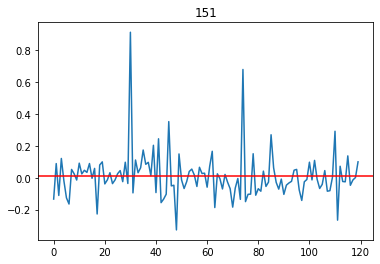

In [26]:
n=2
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '417')

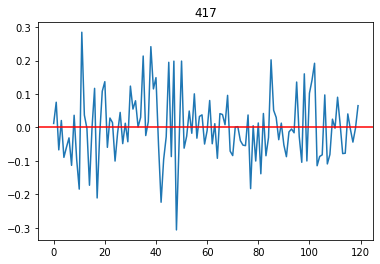

In [27]:
n=3
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '521')

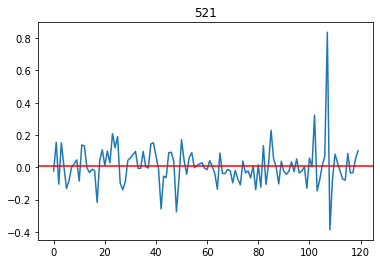

In [28]:
n=4
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '753')

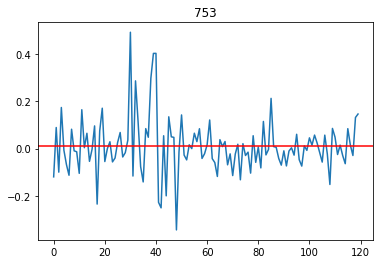

In [29]:
n=5
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '888')

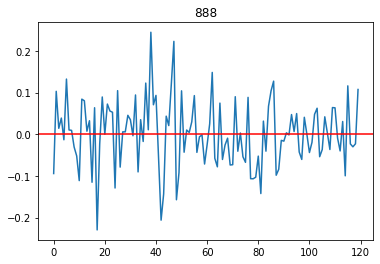

In [30]:
n=6
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '951')

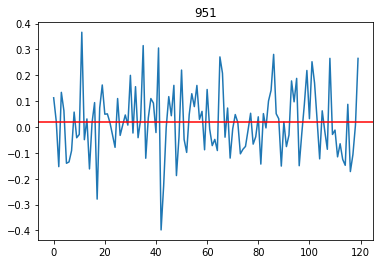

In [31]:
n=7
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '2258')

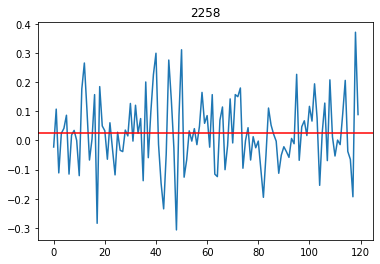

In [32]:
n=8
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '2281')

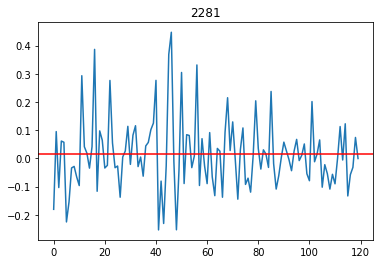

In [33]:
n=9
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '600000')

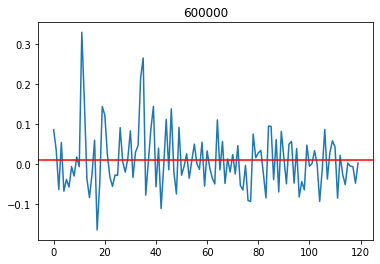

In [34]:
n=10
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '600030')

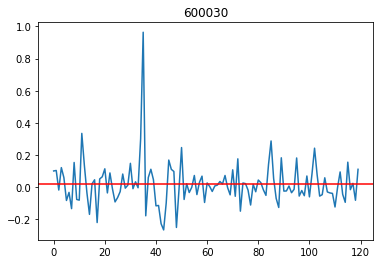

In [35]:
n=11
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '600036')

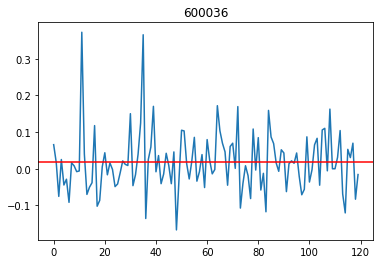

In [36]:
n=12
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '600348')

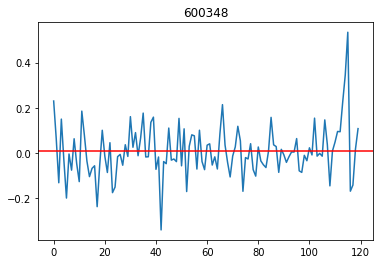

In [37]:
n=13
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '600519')

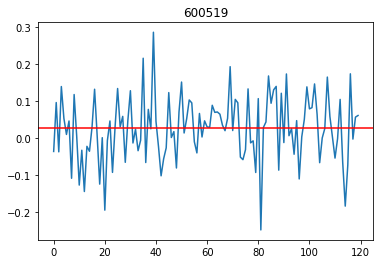

In [38]:
n=14
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '600993')

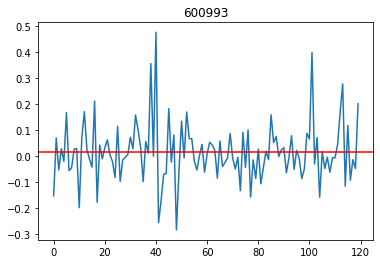

In [39]:
n=15
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '601398')

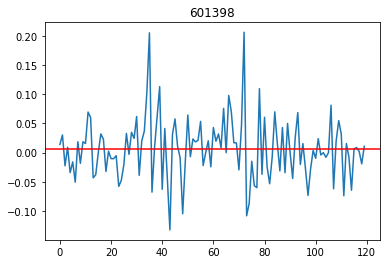

In [40]:
n=16
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '601628')

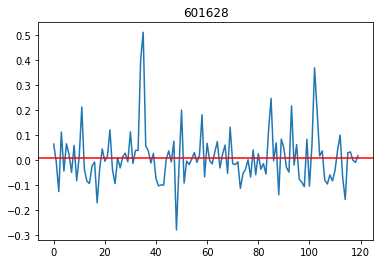

In [41]:
n=17
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '601668')

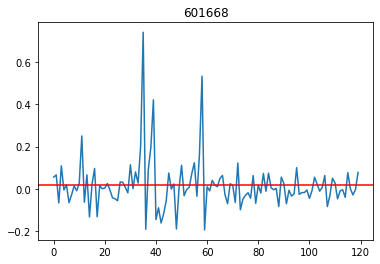

In [42]:
n=18
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

Text(0.5, 1.0, '601857')

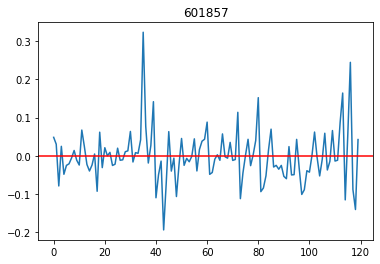

In [43]:
n=19
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

In [44]:
n=20
stock=stock_list[n]
plt.plot(df_main[stock])
plt.axhline(mvdf.iloc[n,1],color="red")
plt.title(stock)

IndexError: list index out of range

In [ ]:
stop

In [ ]:
#The magnitude of changing:
Q=np.transpose(np.array(Q))
Q

In [ ]:
#Get the P matrix
P=np.transpose(np.array(dfd[viewl]))
P

In [ ]:
#tau=0.5 Ω = τdiag(PΣP^T )
tau=0.025
Tem=tau*P@Sigma@np.transpose(P)
dia=[]
for i in range(N):
    dia.append(Tem[i][i])
Omega=np.diag(dia)
Omega

In [ ]:
#Get the expected return function
def mu_P(w):
    mup=np.linalg.inv(np.linalg.inv(tau*Sigma)+np.transpose(P)@np.linalg.inv(Omega)@P)@(np.linalg.inv(tau*Sigma)@Pi+np.transpose(P)@np.linalg.inv(Omega)@Q)
    return mup

In [ ]:
m=len(stock_list)
w = cp.Variable(m)
l=np.ones(m)
e=mu_P(w)@w
BE=beta@w
var = cp.quad_form(w,0.5*Sigma)
Rm=0.022423
objective = cp.Minimize(var)
constraints = [l@w ==1, w>=0,e-rf-BE*(Rm-rf)==0]
prob = cp.Problem(objective, constraints)
prob.solve()
print(prob.value)
print(w.value)
print(mu_P(w.value)@w.value)

In [ ]:
variance=[]
mean=[]
for i in range(200):
    o=i-100
    z=o*0.001
    w = cp.Variable(m)
    l=np.ones(m)
    e=mu_P(w)@w
    var = cp.quad_form(w,Sigma)
    objective = cp.Minimize(0.5*var)
    constraints = [l@w ==1, w>=0,e==z]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    variance.append(prob.value)
    mean.append(z)
variance

In [ ]:
v=[]
k=[]
for i in range(400,1000):
    o=i
    z=o*0.00001
    w = cp.Variable(m)
    l=np.ones(m)
    e=Pi@w
    var = cp.quad_form(w,Sigma)
    objective = cp.Minimize(0.5*var)
    constraints = [l@w ==1, w>=0,e==z]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    v.append(prob.value)
    k.append(z)
    print(prob.value)
v

In [ ]:
plt.plot(v,k,color="red")
plt.show()

In [ ]:

plt.plot(variance,mean)
plt.show()